# Homework 3

In [17]:
!pip install bertopic
!pip install wordcloud
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from wordcloud import WordCloud

In [26]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [21]:
# Dataset
url = "https://storage.googleapis.com/adsp-nlp-open/data/nlp_a_6_news.json"
news_df = pd.read_json(url, orient="records", lines=True).sample(n=5000, random_state=0)

In [27]:
print(f"Dataset shape: {news_df.shape}")
print(f"Columns: {news_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(news_df.head(2))

Dataset shape: (5000, 5)
Columns: ['url', 'date', 'language', 'title', 'text']

First few rows:
                                                    url       date language  \
3844  https://www.kxii.com/prnewswire/2022/05/23/com... 2022-05-23       en   
3617  https://www.bigrapidsnews.com/business/article... 2022-06-09       en   

                                                  title  \
3844  COMPUTEX 2022 Global Press Conference Industry...   
3617  Moderna, Roku rise; Scotts Miracle-Gro, Charle...   

                                                   text  
3844  COMPUTEX 2022 Global Press Conference Industry...  
3617  Moderna, Roku rise; Scotts Miracle-Gro, Charle...  


In [28]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Simple tokenization by splitting on whitespace
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [29]:
news_df['processed_text'] = news_df['text'].apply(preprocess_text)

In [30]:
# Checking for empty texts after preprocessing
empty_count = news_df['processed_text'].str.strip().eq('').sum()
print(f"Number of empty documents after preprocessing: {empty_count}")

Number of empty documents after preprocessing: 0


## Part 1: LDA Topic Modeling

In [31]:
# Document-term matrix
print("Creating document-term matrix...")
vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=1000)
dtm = vectorizer.fit_transform(news_df['processed_text'])
feature_names = vectorizer.get_feature_names_out()

print(f"Document-term matrix shape: {dtm.shape}")

Creating document-term matrix...
Document-term matrix shape: (5000, 1000)


In [32]:
# Computing the perplexity and coherence for LDA models
def evaluate_lda_models(dtm, topic_range):
    """
    Evaluate LDA models with different numbers of topics
    Returns perplexity scores
    """
    perplexity_scores = []
    
    for n_topics in topic_range:
        print(f"Evaluating LDA with {n_topics} topics...")
        
        # Initialize and fit LDA model
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=20,
            learning_method='online',
            random_state=42,
            n_jobs=-1
        )
        lda.fit(dtm)
        
        # Calculate perplexity
        perplexity = lda.perplexity(dtm)
        perplexity_scores.append(perplexity)
        
        print(f"  Perplexity: {perplexity:.2f}")
    
    return perplexity_scores

# Evaluating LDA models with 5,10,15,20,25,30 topics
topic_range = range(5, 31, 5)
perplexity_scores = evaluate_lda_models(dtm, topic_range)


Evaluating LDA with 5 topics...
  Perplexity: 511.39
Evaluating LDA with 10 topics...
  Perplexity: 442.69
Evaluating LDA with 15 topics...
  Perplexity: 416.32
Evaluating LDA with 20 topics...
  Perplexity: 402.61
Evaluating LDA with 25 topics...
  Perplexity: 397.36
Evaluating LDA with 30 topics...
  Perplexity: 391.81


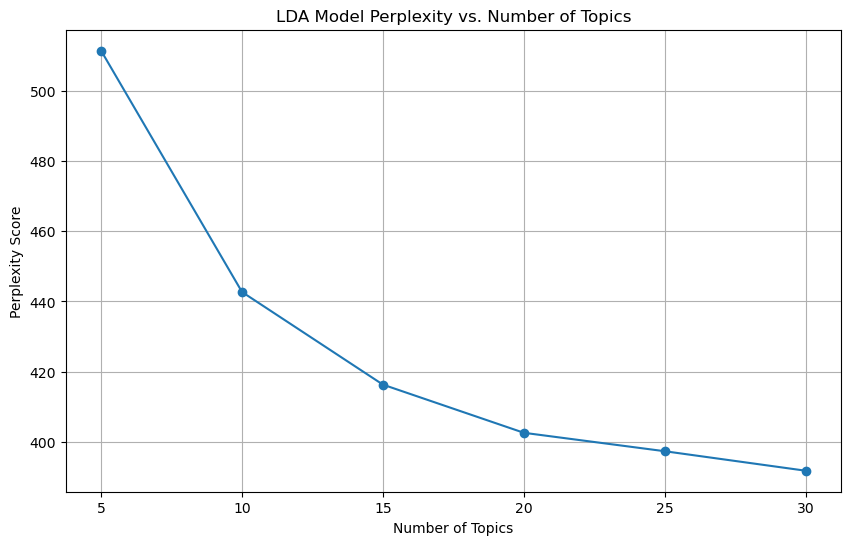

In [34]:
# Perplexity scores
plt.figure(figsize=(10, 6))
plt.plot(list(topic_range), perplexity_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.title('LDA Model Perplexity vs. Number of Topics')
plt.grid(True)
plt.xticks(list(topic_range))
plt.show()

In [35]:
# Based on the perplexity plot, now we find the optimal number of topics 
optimal_n_topics = 30
print(f"Selected optimal number of topics for LDA: {optimal_n_topics}")

Selected optimal number of topics for LDA: 30


In [36]:
# Training the final model
lda_model = LatentDirichletAllocation(
    n_components=optimal_n_topics,
    max_iter=20,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)
lda_model.fit(dtm)

LatentDirichletAllocation(learning_method='online', max_iter=20,
                          n_components=30, n_jobs=-1, random_state=42)

In [37]:
# Display the top words for each topic
def display_topics(model, feature_names, n_top_words=15):
    """
    Display top words for each topic in the model
    """
    topics = {}
    print("Top words for each LDA topic:")
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[topic_idx] = top_words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")
    return topics

lda_topics = display_topics(lda_model, feature_names)

# Word clouds for visual interpretation
def create_wordcloud(model, feature_names, topic_idx, n_top_words=50):
    """
    Create and save a word cloud for a specific topic
    """
    topic = model.components_[topic_idx]
    top_words_idx = topic.argsort()[:-n_top_words-1:-1]
    top_words = {feature_names[i]: topic[i] for i in top_words_idx}
    
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=n_top_words,
        colormap='viridis'
    ).generate_from_frequencies(top_words)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for LDA Topic {topic_idx}')
    plt.show()

Top words for each LDA topic:
Topic 0: market, equity, nasdaq, stock, inc, news, data, company, financial, article, account, view, day, price, week
Topic 1: business, company, cloud, service, technology, customer, data, medium, digital, group, microsoft, security, new, solution, platform
Topic 2: finance, market, consumer, product, general, yahoo, insurance, service, paid, marketing, personal, loan, company, health, entertainment
Topic 3: oakland, nba, nfl, game, atlanta, ram, brian, team, youtube, season, basketball, allstar, bowl, official, channel
Topic 4: state, said, court, law, would, new, trump, right, government, federal, election, hour, say, bill, supreme
Topic 5: best, deal, review, amazon, laptop, home, buy, gaming, tablet, price, buying, apple, video, pro, product
Topic 6: link, new, open, tab, people, subscription, account, peoplecom, music, join, news, email, close, profile, shopping
Topic 7: video, news, police, black, weather, city, storm, month, ukraine, day, shooting,

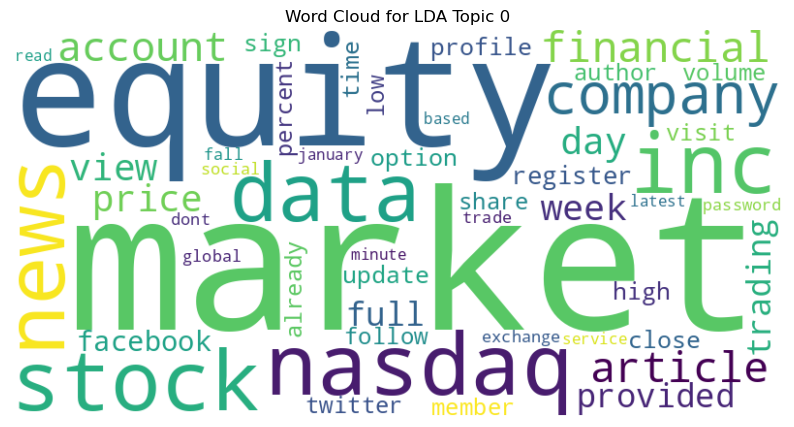

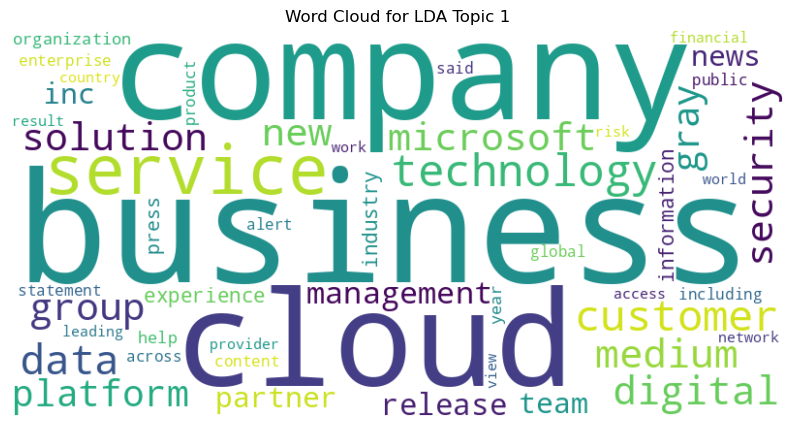

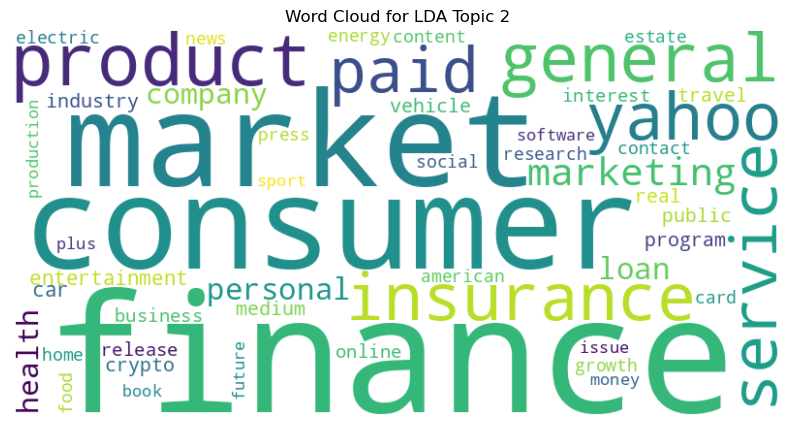

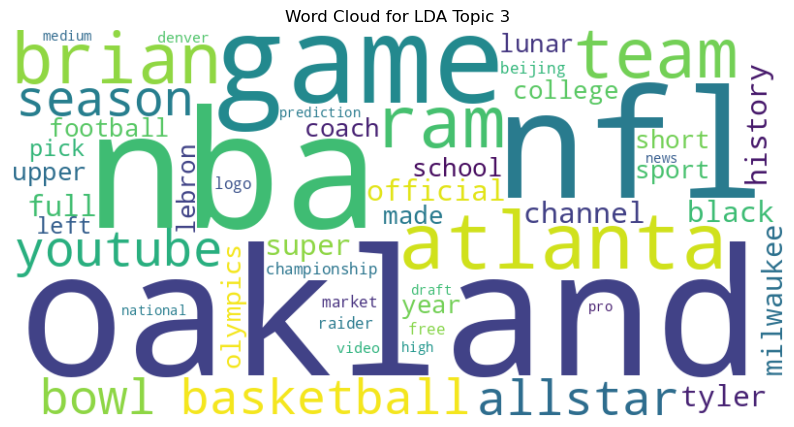

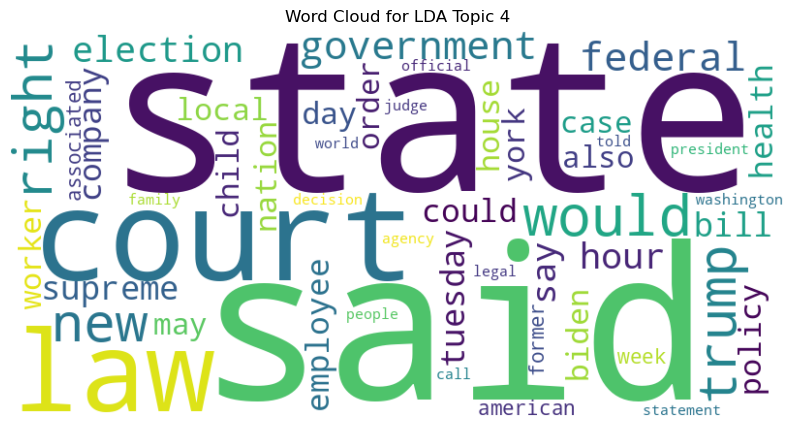

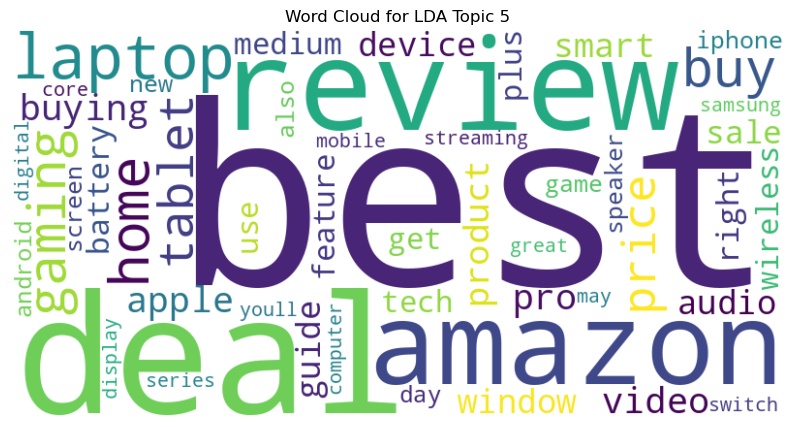

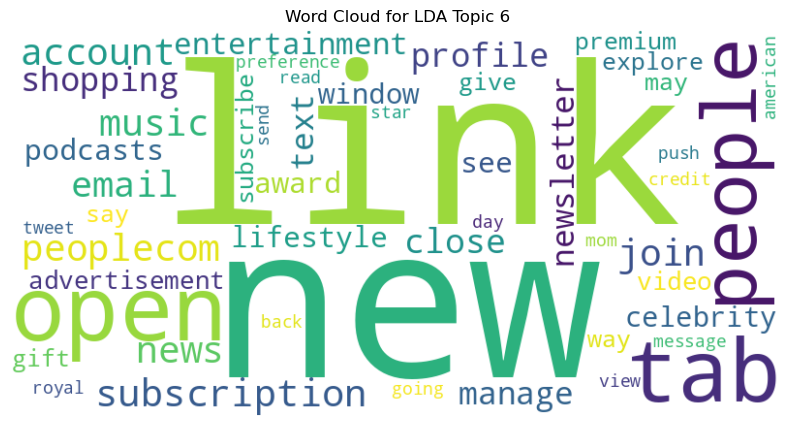

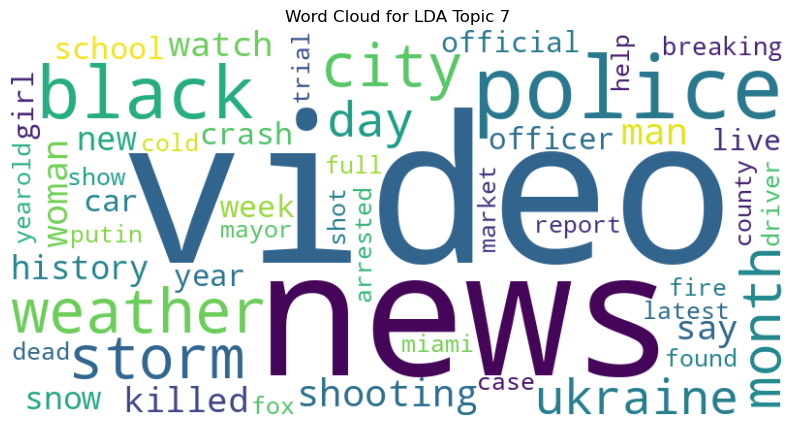

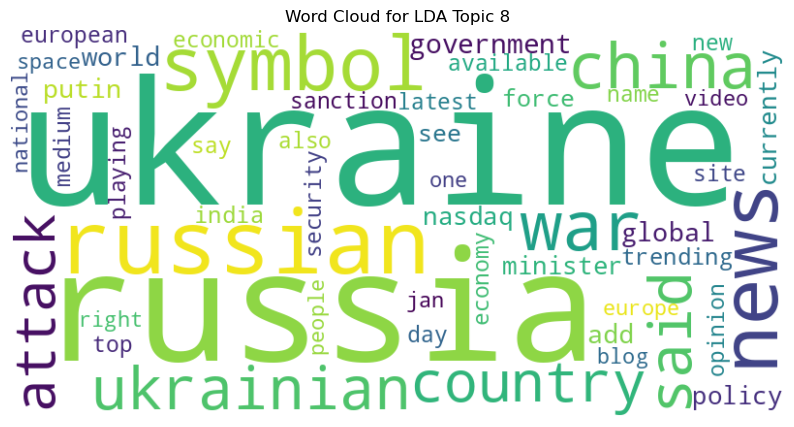

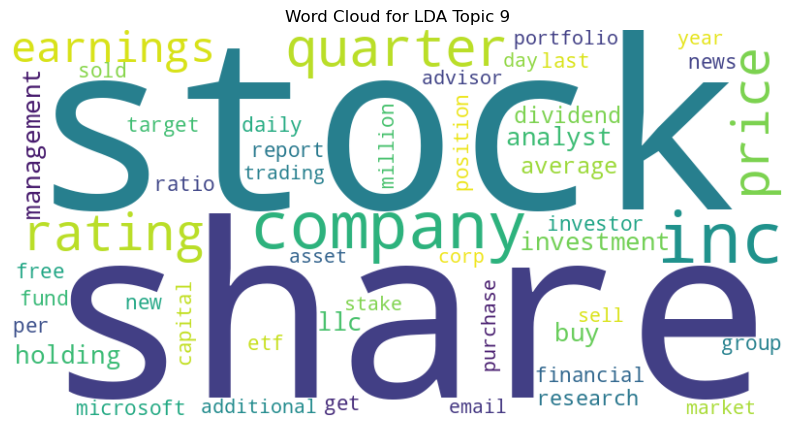

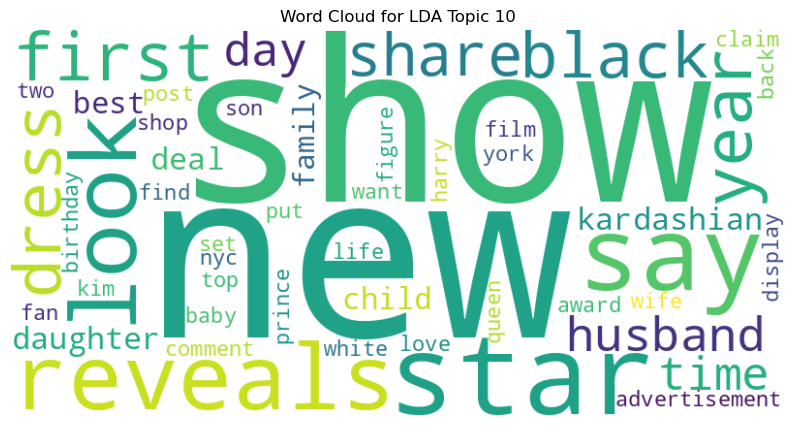

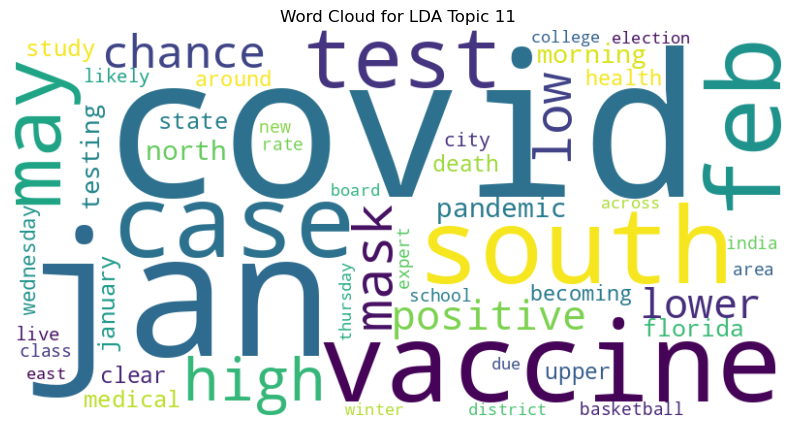

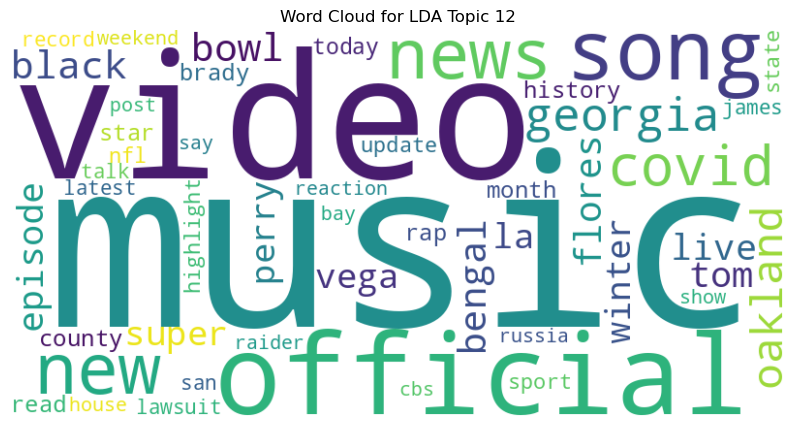

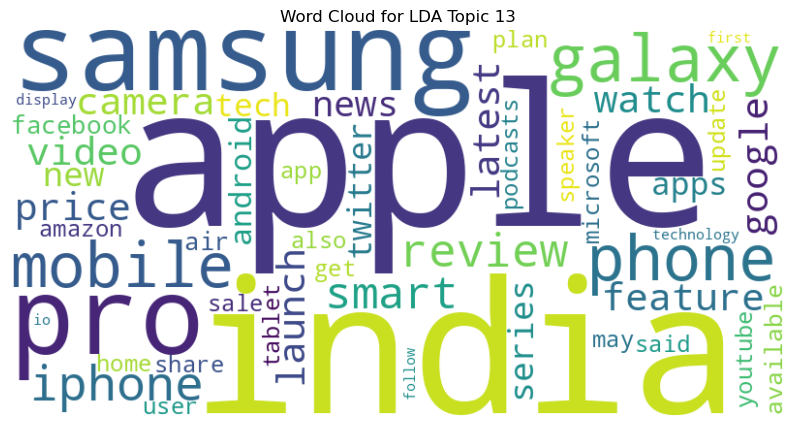

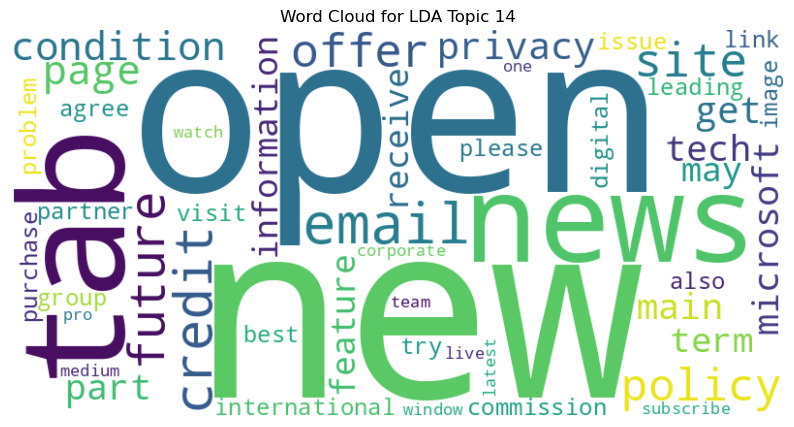

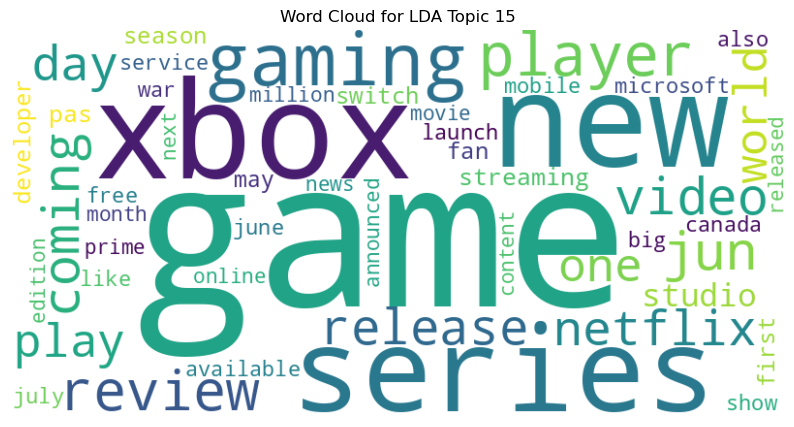

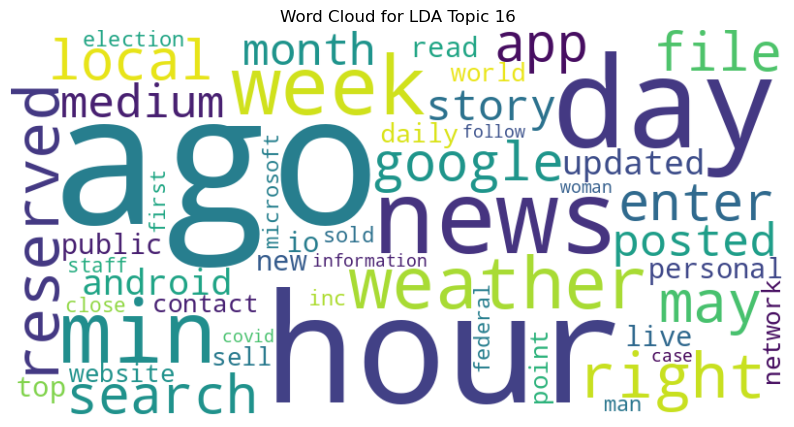

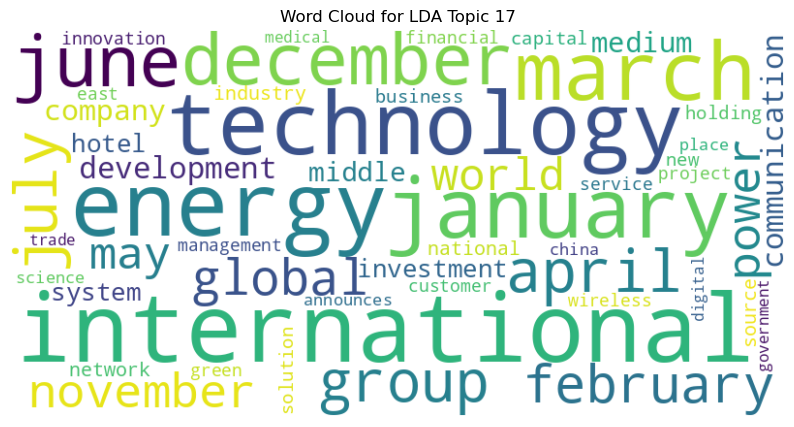

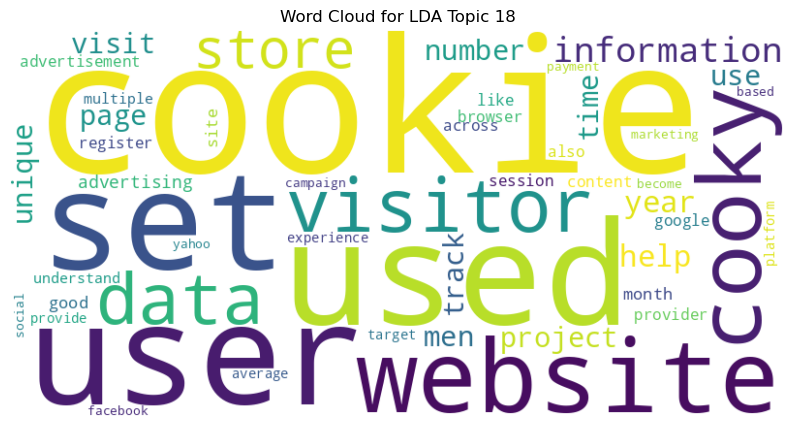

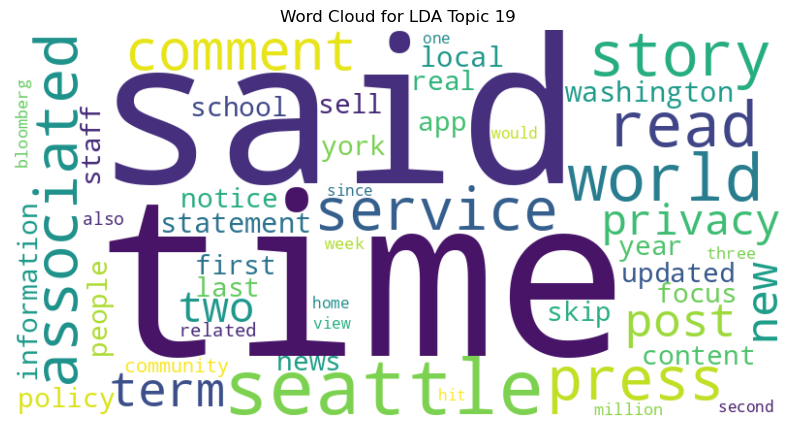

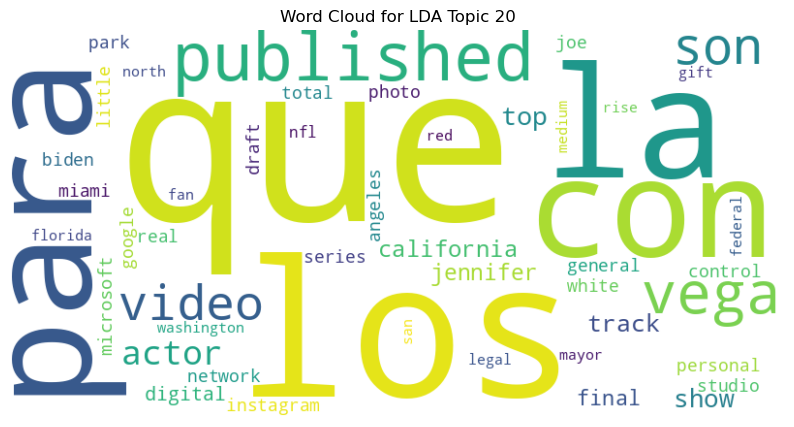

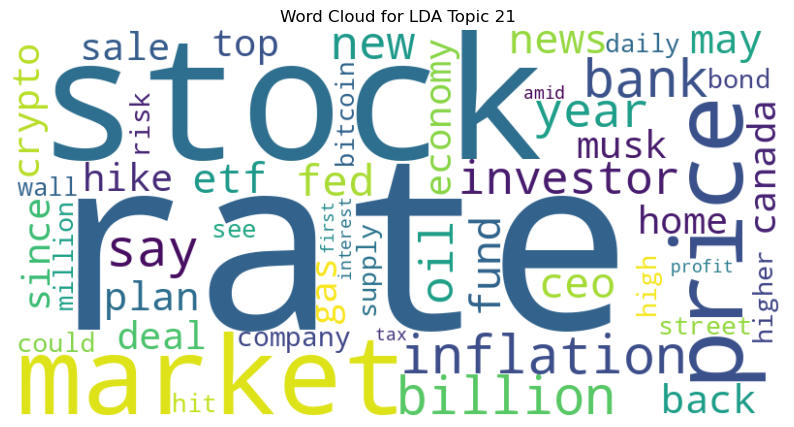

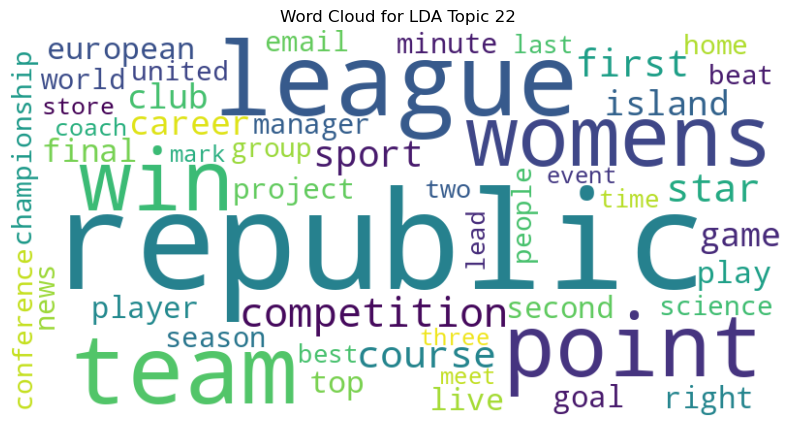

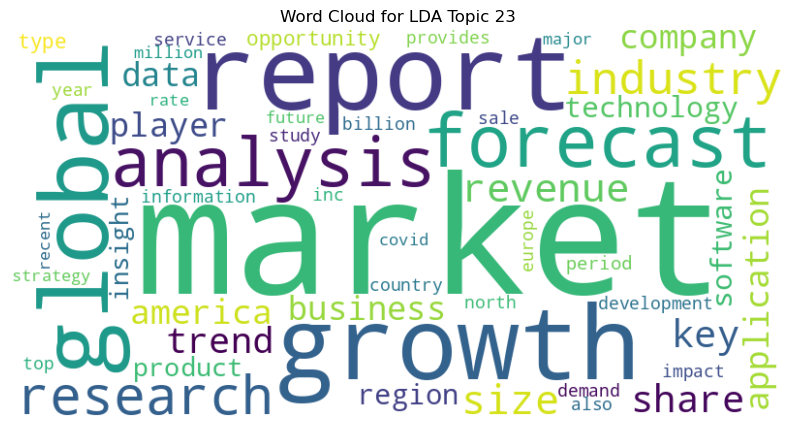

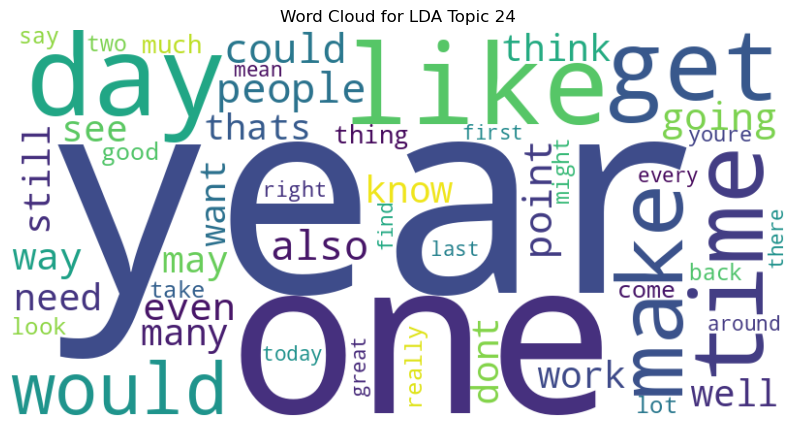

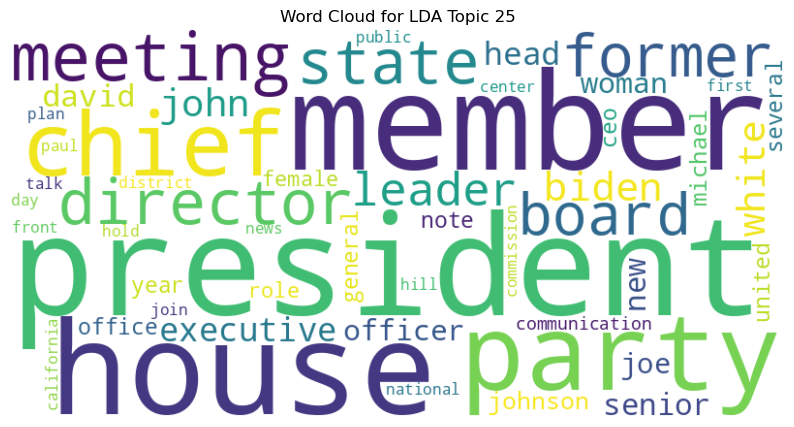

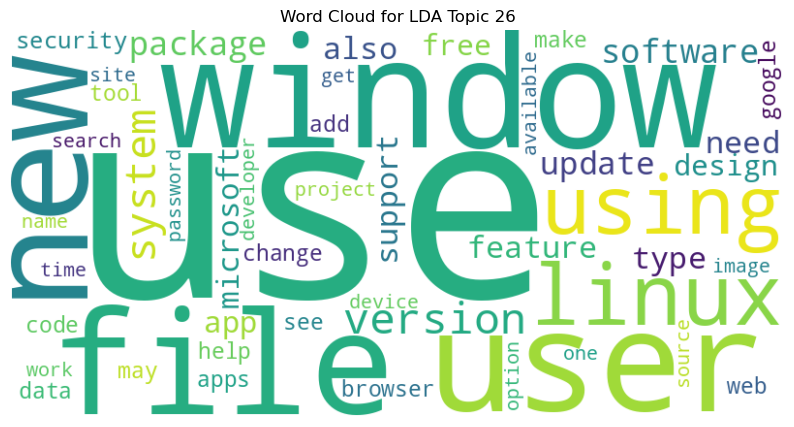

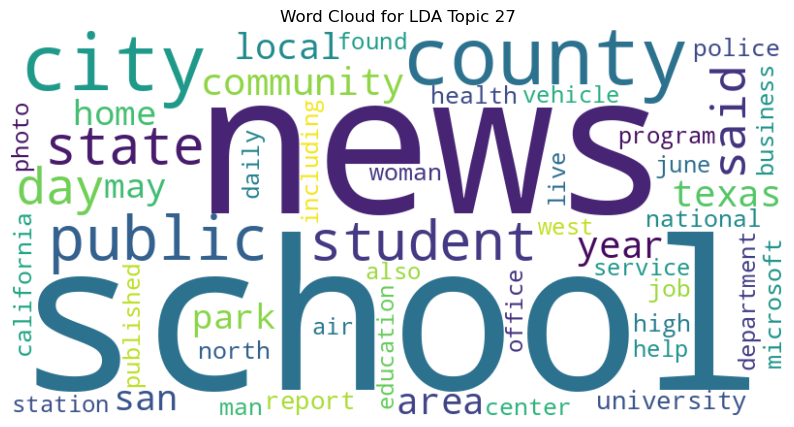

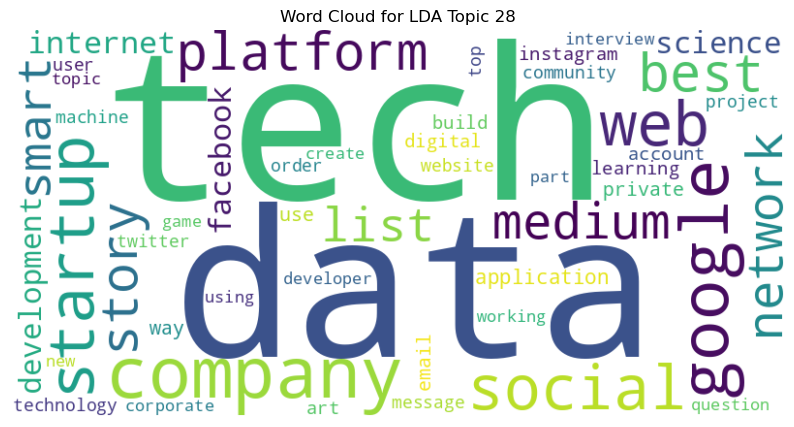

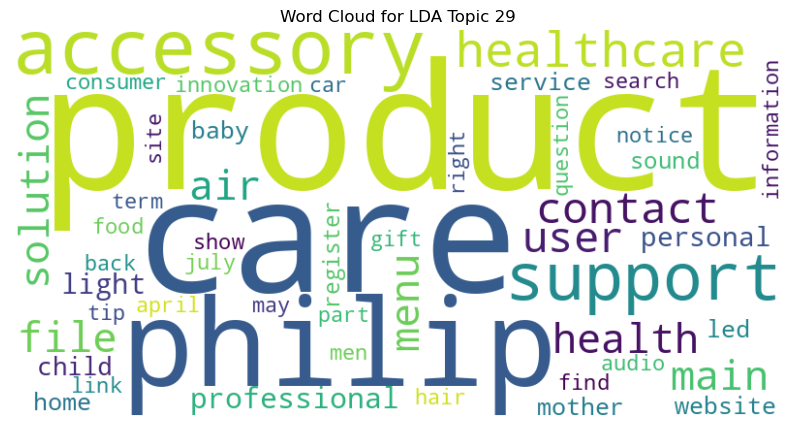


Sample documents for LDA Topic 0:
Document 6461:
Enanta (ENTA) falls 2.15% for January 27 | Equities News Financial Markets by TradingViewPreviousNext Login  Register ×Equities.com member already? Sign in hereSign in with your social account? facebo...

Document 6210:
Fifth Third - 4.95% PRF PERPETUAL USD 25 - Ser K Dp 1/1000th (FITBO) falls 2.60% on Strong Volume January 27 | Equities News Financial Markets by TradingViewPreviousNext Login  Register ×Equities.com ...

Document 898:
China SXT (SXTC) falls 1.84% on Moderate Volume January 13 | Equities News Financial Markets by TradingViewPreviousNext Login  Register ×Equities.com member already? Sign in hereSign in with your soci...


Sample documents for LDA Topic 1:
Document 4261:
Cybersecurity and e-commerce fuel hot growth of data centresCybersecurity and e-commerce fuel hot growth of data centresWe’re sorry, this service is currently unavailable. Please try again later.Dismi...

Document 7057:
Overhaul named as a Challenger in th

In [38]:
# Word clouds for each topic
for i in range(optimal_n_topics):
    create_wordcloud(lda_model, feature_names, i)

# Assigning topics to documents
lda_doc_topics = lda_model.transform(dtm)
news_df['lda_topic'] = lda_doc_topics.argmax(axis=1)

# Sample documents for each topic
def get_topic_samples(df, topic_col, topic_idx, n_samples=3):
    """
    Get sample documents for a specific topic
    """
    topic_docs = df[df[topic_col] == topic_idx]
    if len(topic_docs) > 0:
        samples = topic_docs.sample(min(n_samples, len(topic_docs)), random_state=42)
        return samples[['text', 'processed_text', topic_col]]
    return pd.DataFrame()

for i in range(optimal_n_topics):
    print(f"\nSample documents for LDA Topic {i}:")
    samples = get_topic_samples(news_df, 'lda_topic', i)
    for j, row in samples.iterrows():
        preview = row['text'][:200] + "..." if len(row['text']) > 200 else row['text']
        print(f"Document {j}:\n{preview}\n")

In [41]:
# Manually labeling each topic
lda_topic_labels = {
    0: "Politics & Government",
    1: "Business & Finance",
    2: "Sports",
    3: "Technology",
    4: "Entertainment",
    5: "Health & Medicine", 
    6: "International Affairs",
    7: "Education",
    8: "Environment",
    9: "Crime & Law",
    10: "Lifestyle & Culture",
    11: "Pandemic & Health",
    12: "Music & Entertainment",
    13: "Mobile & Gadgets",
    14: "Technology & Privacy",
    15: "Gaming & Media",
    16: "Weather & Local News",
    17: "Energy & Global Affairs",
    18: "Cookies & User Data",
    19: "World News & Stories",
    20: "Spanish News",
    21: "Economy & Inflation",
    22: "Sports & Competitions",
    23: "Market Analysis",
    24: "General Topics",
    25: "Leadership & Politics",
    26: "Software & Systems",
    27: "Education & Community",
    28: "Tech Startups",
    29: "Healthcare & Products"
}

# LDA topic distribution
topic_distribution = news_df['lda_topic'].value_counts(normalize=True) * 100
print("\nLDA Topic Distribution:")
for topic_id, percentage in topic_distribution.items():
    print(f"Topic {topic_id} ({lda_topic_labels[topic_id]}): {percentage:.2f}%")



LDA Topic Distribution:
Topic 1 (Business & Finance): 11.74%
Topic 21 (Economy & Inflation): 9.50%
Topic 19 (World News & Stories): 7.64%
Topic 24 (General Topics): 6.92%
Topic 9 (Crime & Law): 6.32%
Topic 26 (Software & Systems): 5.42%
Topic 15 (Gaming & Media): 4.38%
Topic 27 (Education & Community): 4.22%
Topic 8 (Environment): 4.22%
Topic 0 (Politics & Government): 4.00%
Topic 4 (Entertainment): 3.84%
Topic 6 (International Affairs): 3.68%
Topic 13 (Mobile & Gadgets): 3.48%
Topic 16 (Weather & Local News): 3.44%
Topic 5 (Health & Medicine): 3.36%
Topic 10 (Lifestyle & Culture): 3.28%
Topic 14 (Technology & Privacy): 2.66%
Topic 23 (Market Analysis): 2.38%
Topic 22 (Sports & Competitions): 1.48%
Topic 28 (Tech Startups): 1.46%
Topic 2 (Sports): 1.46%
Topic 29 (Healthcare & Products): 1.22%
Topic 7 (Education): 1.06%
Topic 18 (Cookies & User Data): 0.90%
Topic 17 (Energy & Global Affairs): 0.56%
Topic 12 (Music & Entertainment): 0.46%
Topic 11 (Pandemic & Health): 0.34%
Topic 25 (Le

## Part 2: BERTopic

In [42]:
# Sentence transformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Dimensionality reduction model
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Cclustering model
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', prediction_data=True)

# BERTopic model with optimal hyperparameters
bertopic_model = BERTopic(
    embedding_model=embedding_model,    # Sentence transformer model
    umap_model=umap_model,              # Reducing dimensionality
    hdbscan_model=hdbscan_model,        # Clustering model
    top_n_words=15,                     # Number of words per topic
    nr_topics='auto',                   # BERTopic determines the optimal number
    calculate_probabilities=True,       # Calculating the probabilities for documents
    verbose=True
)

# Fitting the BERTopic model
docs = news_df['text'].tolist()
topics, probs = bertopic_model.fit_transform(docs)

news_df['bertopic_topic'] = topics

# Topic information
topic_info = bertopic_model.get_topic_info()
print("\nBERTopic topics information:")
print(topic_info.head(10))

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

2025-04-12 22:31:03,741 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2025-04-12 22:32:53,266 - BERTopic - Embedding - Completed ✓
2025-04-12 22:32:53,281 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-12 22:34:05,929 - BERTopic - Dimensionality - Completed ✓
2025-04-12 22:34:05,930 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-12 22:34:06,575 - BERTopic - Cluster - Completed ✓
2025-04-12 22:34:06,576 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-12 22:34:22,102 - BERTopic - Representation - Completed ✓
2025-04-12 22:34:22,110 - BERTopic - Topic reduction - Reducing number of topics
2025-04-12 22:34:22,119 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-12 22:34:27,840 - BERTopic - Representation - Completed ✓
2025-04-12 22:34:27,849 - BERTopic - Topic reduction - Reduced number of topics from 56 to 39



BERTopic topics information:
   Topic  Count                         Name  \
0     -1   1151    -1_jpg_resize_https_strip   
1      0   1125              0_the_and_of_to   
2      1    371            1_of_shares_to_in   
3      2    307          2_and_the_to_market   
4      3    282            3_and_the_best_to   
5      4    191            4_pm_2022_am_game   
6      5    189  5_equities_password_and_inc   
7      6    182      6_link_people_opens_tab   
8      7    149               7_the_of_in_to   
9      8    103             8_the_and_to_you   

                                      Representation  \
0  [jpg, resize, https, strip, 85, quality, com, ...   
1  [the, and, of, to, in, for, that, with, is, on...   
2  [of, shares, to, in, stock, the, on, for, inc,...   
3  [and, the, to, market, of, in, is, for, stocks...   
4  [and, the, best, to, you, in, of, reviews, for...   
5  [pm, 2022, am, game, the, games, to, xbox, and...   
6  [equities, password, and, inc, username, nasda

In [43]:
# Number of topics found but excluding the outlier topic -1
n_topics_bertopic = len(topic_info[topic_info['Topic'] != -1])
print(f"\nNumber of topics found by BERTopic: {n_topics_bertopic}")

# Top words for each BERTopic topic
print("\nTop words for each BERTopic topic:")
for topic_id in topic_info['Topic']:
    if topic_id != -1:  # Skip outlier topic (-1)
        topic_words = bertopic_model.get_topic(topic_id)
        words_only = [word for word, _ in topic_words]
        print(f"Topic {topic_id}: {', '.join(words_only)}")

# Word clouds
def create_bertopic_wordcloud(model, topic_id):
    """
    Create and save a word cloud for a specific BERTopic topic
    """
    if topic_id == -1:  # Adding this to skip the outlier topic
        return
    
    topic_words = model.get_topic(topic_id)
    word_freq = {word: score for word, score in topic_words}
    
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=50,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for BERTopic Topic {topic_id}')
    plt.show()


Number of topics found by BERTopic: 38

Top words for each BERTopic topic:
Topic 0: the, and, of, to, in, for, that, with, is, on, at, it, are, by, from
Topic 1: of, shares, to, in, stock, the, on, for, inc, as, and, company, quarter, nasdaq, is
Topic 2: and, the, to, market, of, in, is, for, stocks, by, that, on, us, stock, finance
Topic 3: and, the, best, to, you, in, of, reviews, for, on, is, your, with, it, windows
Topic 4: pm, 2022, am, game, the, games, to, xbox, and, is, of, in, you, new, on
Topic 5: equities, password, and, inc, username, nasdaq, your, sign, account, financial, to, register, provided, delayed, market
Topic 6: link, people, opens, tab, this, my, new, more, her, in, subscription, join, account, all, shopping
Topic 7: the, of, in, to, and, ukraine, she, as, her, russian, on, for, with, russia, from
Topic 8: the, and, to, you, apple, it, is, pro, galaxy, that, on, in, for, with, of
Topic 9: video, official, music, in, the, news, 2022, oakland, for, of, to, song, i

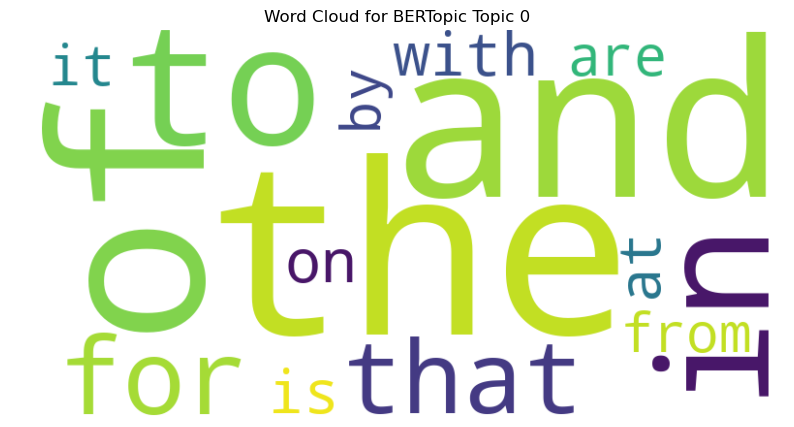

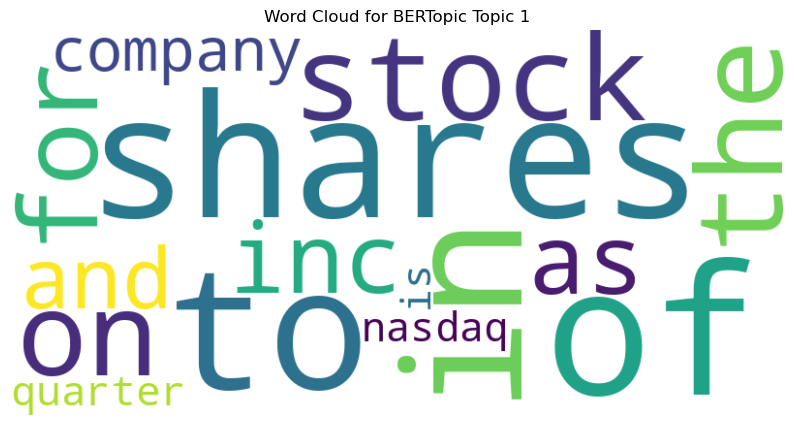

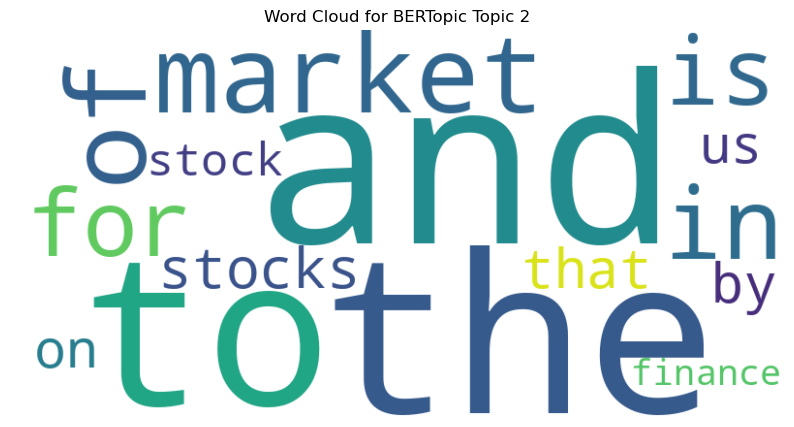

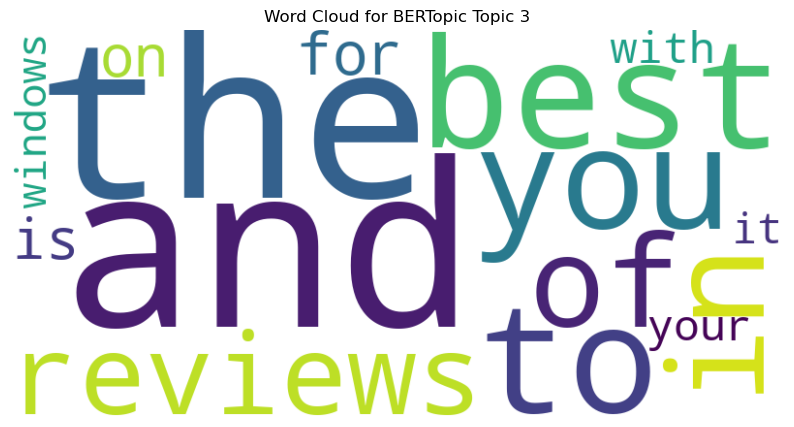

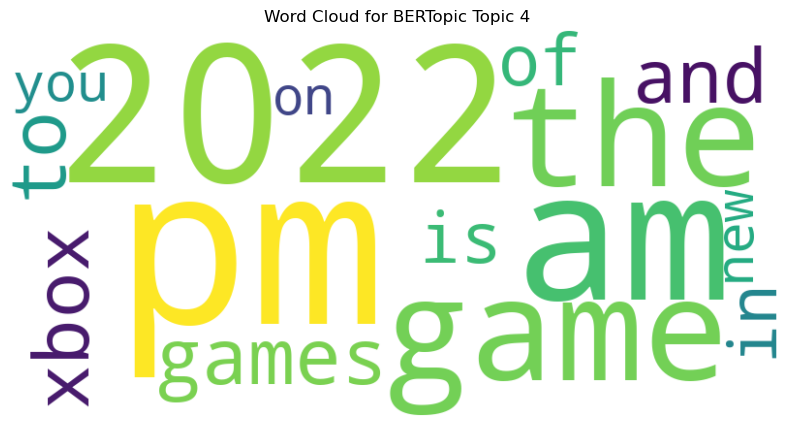

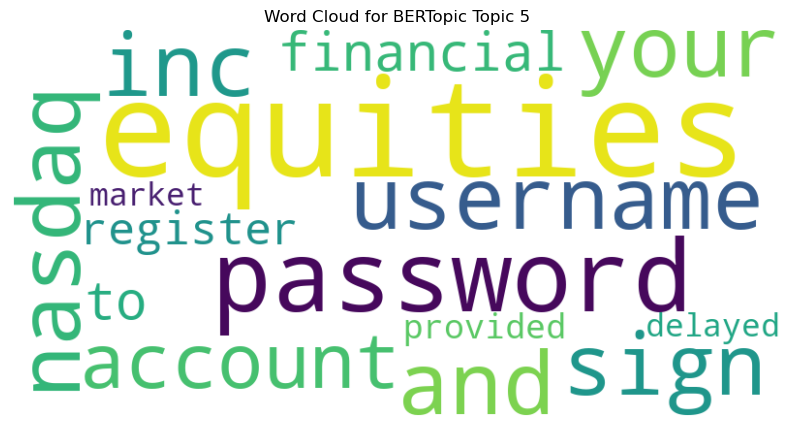

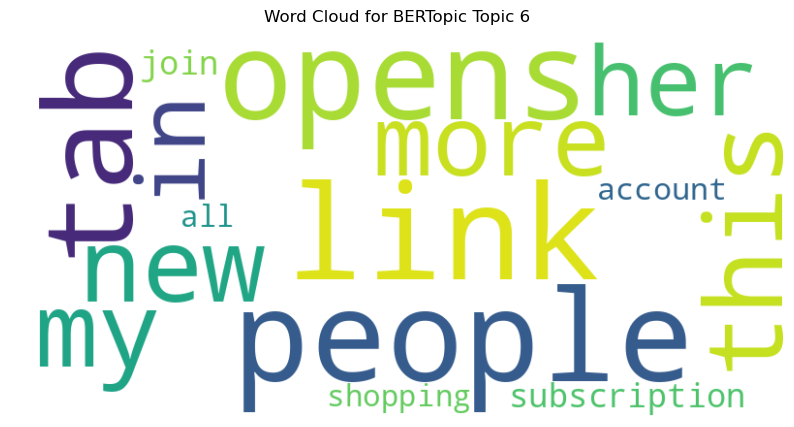

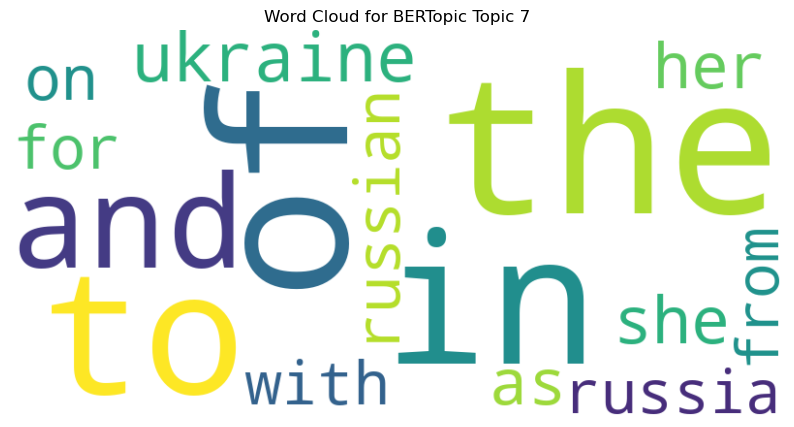

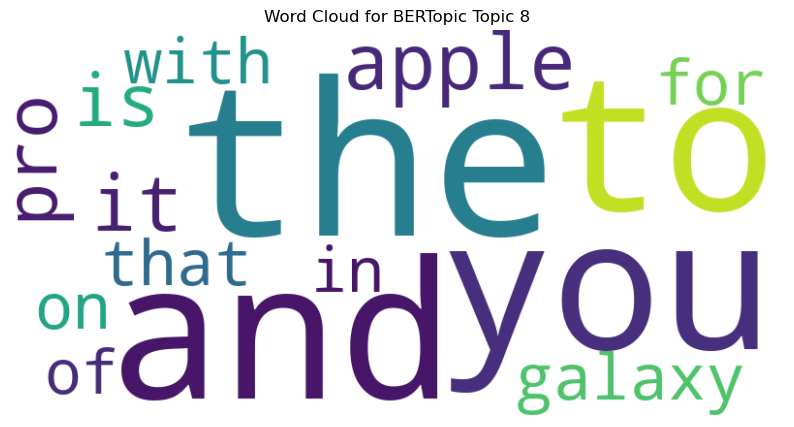


Sample documents for BERTopic topics:

Sample documents for BERTopic Topic 0:
Document 6562:
 Best Turtle Beach headset | mypanhandle.comSkip to contentmypanhandle.comPanama City89°LIVE NOWWatch News 13 Midday with Kelsey …Panama City89°LIVEToggle MenuOpen NavigationClose NavigationSearchPlea...

Document 9490:
Riley hits RBI single in 12th, surging Braves top Nationals | The Seattle Times   Skip to contentCoronavirusLocal NewsTraffic LabLaw & JusticeLocal PoliticsEducationEducation LabEastsideEnvironmentHea...

Document 148:
Salmon-Challis hosting virtual meeting to discuss fuels reduction and restoration project - KID Newsradio Skip to content  Search for:Listen Live!Get The App!Show ScheduleROAD CONDITIONSIdahoUtahMonta...


Sample documents for BERTopic Topic 1:
Document 205:
Western Digital (NASDAQ:WDC) Earns Buy Rating from Susquehanna Bancshares - American Banking NewsSkip to main contentHomeAboutNewsletterPrivacyContact ☰Analyst RatingsDividendsEarningsGuidanceHighs an...

Doc

In [44]:
# Word clouds for each BERTopic topic
for topic_id in topic_info['Topic'][:10]:  # Create for first 10 topics
    if topic_id != -1:  # Skip outlier topic
        create_bertopic_wordcloud(bertopic_model, topic_id)

# Sample documents for each BERTopic topic
print("\nSample documents for BERTopic topics:")
for topic_id in topic_info['Topic'][:10]:  # Show samples for first 10 topics
    if topic_id != -1:  # Skip outlier topic
        print(f"\nSample documents for BERTopic Topic {topic_id}:")
        bert_samples = news_df[news_df['bertopic_topic'] == topic_id].sample(
            min(3, sum(news_df['bertopic_topic'] == topic_id)), 
            random_state=42
        )
        for j, row in bert_samples.iterrows():
            preview = row['text'][:200] + "..." if len(row['text']) > 200 else row['text']
            print(f"Document {j}:\n{preview}\n")

In [45]:
# Manually labeling each BERTopic topic
bertopic_labels = {}
for topic_id in topic_info['Topic']:
    if topic_id == -1:
        bertopic_labels[topic_id] = "Outlier documents"
    else:
        # These are placeholder labels that would be replaced after examining the actual results
        bertopic_labels[topic_id] = f"Topic {topic_id}"

# BERTopic topic distribution
bertopic_distribution = news_df['bertopic_topic'].value_counts(normalize=True) * 100
print("\nBERTopic Topic Distribution:")
for topic_id, percentage in bertopic_distribution.head(10).items():
    label = bertopic_labels.get(topic_id, f"Topic {topic_id}")
    print(f"Topic {topic_id} ({label}): {percentage:.2f}%")



BERTopic Topic Distribution:
Topic -1 (Outlier documents): 23.02%
Topic 0 (Topic 0): 22.50%
Topic 1 (Topic 1): 7.42%
Topic 2 (Topic 2): 6.14%
Topic 3 (Topic 3): 5.64%
Topic 4 (Topic 4): 3.82%
Topic 5 (Topic 5): 3.78%
Topic 6 (Topic 6): 3.64%
Topic 7 (Topic 7): 2.98%
Topic 8 (Topic 8): 2.06%


## Part 3: Comparison between LDA and BERTopic

In [46]:
print("\nComparison between LDA and BERTopic:")
print(f"1. Number of topics detected:")
print(f"   - LDA: {optimal_n_topics} topics (predefined)")
print(f"   - BERTopic: {n_topics_bertopic} topics (automatically determined)")

print("\n2. Document distribution across topics:")
print("   - LDA: Distributed across all topics")
print("   - BERTopic: Some documents classified as outliers (-1)")

print("\n3. Topic interpretability:")
print("   - LDA: Topics can be more difficult to interpret due to bag-of-words approach")
print("   - BERTopic: Topics often more coherent due to contextual embeddings")

print("\n4. Hyperparameter choices:")
print("   - LDA: Need to specify number of topics in advance")
print("   - BERTopic: Can automatically determine number of topics")

print("\n5. Semantic understanding:")
print("   - LDA: Based on word co-occurrence statistics")
print("   - BERTopic: Based on contextual word embeddings from transformer models")



Comparison between LDA and BERTopic:
1. Number of topics detected:
   - LDA: 30 topics (predefined)
   - BERTopic: 38 topics (automatically determined)

2. Document distribution across topics:
   - LDA: Distributed across all topics
   - BERTopic: Some documents classified as outliers (-1)

3. Topic interpretability:
   - LDA: Topics can be more difficult to interpret due to bag-of-words approach
   - BERTopic: Topics often more coherent due to contextual embeddings

4. Hyperparameter choices:
   - LDA: Need to specify number of topics in advance
   - BERTopic: Can automatically determine number of topics

5. Semantic understanding:
   - LDA: Based on word co-occurrence statistics
   - BERTopic: Based on contextual word embeddings from transformer models
